# Qualitative analysis of Compression

In [40]:
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame, read_file, GeoSeries
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import movingpandas as mpd
#from holoviews import opts, dim
import hvplot
import warnings
warnings.simplefilter("ignore")
from geopy.distance import geodesic 
from pyproj import Geod
from shapely.ops import nearest_points
import json
from dtaidistance import dtw_ndim

### Trajectory loading

In [41]:
df= pd.read_csv("datasets/cars_8.csv")
traj = mpd.TrajectoryCollection(data=df, traj_id_col='id', t='Timestamp', x='Longitude', y='Latitude')
traj
#traj.plot_trajectory()

TrajectoryCollection with 1 trajectories

### Compression Douglas Peucker

In [42]:
tolerance = 10/111139 # 10 meters
compressed = mpd.DouglasPeuckerGeneralizer(traj).generalize(tolerance)
compressed.to_point_gdf()
#compressed.plot_trajectory()

,id,geometry
Timestamp,,
2020-06-01 08:56:08.148000,8,POINT (4.46537 50.86107)
2020-06-01 08:56:27.699117,8,POINT (4.46574 50.86188)
2020-06-01 08:57:03.154439,8,POINT (4.46426 50.86217)
2020-06-01 08:57:05.149227,8,POINT (4.46419 50.86221)
2020-06-01 08:57:34.996803,8,POINT (4.46338 50.86305)
...,...,...
2020-06-04 21:55:56.017546,8,POINT (4.46338 50.86305)
2020-06-04 21:56:28.292912,8,POINT (4.46419 50.86221)
2020-06-04 21:56:29.313771,8,POINT (4.46426 50.86217)


In [10]:
%%time
series = traj.to_point_gdf()[["geometry"]].values
series1 = []
for point in series:
    p = point[0]
    series1.append([p.x,p.y])
series1 = np.array(series1, dtype=np.double)

series = compressed.to_point_gdf()[["geometry"]].values
series2 = []
for point in series:
    p = point[0]
    series2.append([p.x,p.y])
series2 = np.array(series2, dtype=np.double)

#d = dtw_ndim.distance(series1, series2)
#d

CPU times: user 111 ms, sys: 4.47 ms, total: 116 ms
Wall time: 102 ms


### Compression TD-TR

In [145]:
tolerance = 10/111139 # 10 meters
compressed = mpd.TopDownTimeRatioGeneralizer(traj).generalize(tolerance)
compressed.to_point_gdf()
#compressed.plot_trajectory()

,id,geometry,direction,speed
Timestamp,,,,
2020-06-01 08:56:08.148000,8,POINT (4.46537 50.86107),15.895840,2.103037
2020-06-01 08:56:27.699117,8,POINT (4.46574 50.86188),17.050363,5.257678
2020-06-01 08:56:32.628663,8,POINT (4.46516 50.86199),285.706469,8.782527
2020-06-01 08:56:34.662347,8,POINT (4.46511 50.86200),282.124104,4.215951
2020-06-01 08:56:38.639256,8,POINT (4.46465 50.86208),285.988035,8.782449
...,...,...,...,...
2020-06-04 21:56:45.848648,8,POINT (4.46461 50.86209),105.915507,6.323368
2020-06-04 21:56:49.996226,8,POINT (4.46511 50.86200),105.987713,8.782450
2020-06-04 21:56:52.386056,8,POINT (4.46521 50.86198),105.706284,6.323415


In [43]:
%%time
series_coords = traj.to_point_gdf().reset_index()[["geometry"]].values
series_time   = traj.to_point_gdf().reset_index()[["Timestamp"]].values

series1 = []
for i in range(len(series_coords)):
    p = series_coords[i][0]
    time = series_time[i][0]
    series1.append([time, p.x, p.y])

series_coords = compressed.to_point_gdf().reset_index()[["geometry"]].values
series_time   = compressed.to_point_gdf().reset_index()[["Timestamp"]].values
series2 = []
for i in range(len(series_coords)):
    p = series_coords[i][0]
    time = series_time[i][0]
    series2.append([time, p.x, p.y])
#d = dtw_ndim.distance(series1, series2)
#d

CPU times: user 117 ms, sys: 11.3 ms, total: 128 ms
Wall time: 118 ms


In [47]:
def dist(coord1, coord2):
    return geodesic(coord1, coord2).m

In [143]:
def pairs(lst):
    for i in range(1, len(lst)):
        yield lst[i-1], lst[i]


def collinear(x1, y1, x2, y2, x3, y3):
    slop1 = (y1 - y2) * (x1 - x3)
    slop2 = (y1 - y3) * (x1 - x2)
    #print(slop1, slop2)
    return slop1 == slop2

def get_end_point(line, point):
    min_dist = np.inf
    res=None
    for pair in pairs(line):
        d = LineString([(pair[0][1],pair[0][2]),(pair[1][1],pair[1][2])]).distance(point)
        if d < min_dist:
            min_dist = d
            res = pair[0],pair[1]
    return res

In [50]:
def compute_ED(initial, compressed):
    ED = []
    A = initial[0]
    compressed_path = LineString([Point(p[1], p[2]) for p in compressed]) 
    for i in range(len(initial)):
        B =  initial[i]
        point_B = Point(B[1], B[2])
        _point_B = compressed_path.interpolate(compressed_path.project(point_B))
        #ED.append(point_B.distance(compressed_path))
        ED.append(dist((_point_B.x,_point_B.y), ((B[1], B[2]))))
    return ED
data = compute_ED(series1, series2)
sum(data)/len(data)

2.23446420218803

In [137]:
def compute_SED(initial, compressed):
    """
    A -> B -> C
    """
    SED = []
    for index1, B in initial.iterrows():
        B_time = B["Timestamp"]
        B_point = B["geometry"]
        for index2, C in compressed.iterrows():
            if index2 > 0:
                A_time = A["Timestamp"]
                A_point = A["geometry"]
                C_time = C["Timestamp"]
                C_point = C["geometry"]
                if A_time <= B_time and B_time <= C_time:
                    Vx_AC = (C_point.x - A_point.x) / (C_time - A_time).total_seconds()
                    Vy_AC = (C_point.y - A_point.y) / (C_time - A_time).total_seconds()

                    _Bx =  A_point.x + Vx_AC * (B_time - A_time).total_seconds()
                    _By =  A_point.y + Vy_AC * (B_time - A_time).total_seconds()

                    SED.append(dist((_Bx,_By), (B_point.x, B_point.y)))                    
            A=C
    return SED
data = compute_SED(traj.to_point_gdf().reset_index(), compressed.to_point_gdf().reset_index())
sum(data)

13396.956900132003

In [126]:
sum(data)

146081.07258307745

In [119]:
def compute_speed_score(initial,compressed):
    prec = None
    go = False
    hist_data = []
    error_col = []
    for index, row in compressed.iterrows():
        if go:
            time1 = pd.to_datetime(prec["Timestamp"])
            time2 = pd.to_datetime(row["Timestamp"])
            initial_ = initial[(initial["Timestamp"] >= time1) & (initial["Timestamp"] <= time2)]
            speed1 = prec["speed"]
            speed2 = row["speed"]
            speed_compressed_avg = (speed1+speed2)/2
            speed_error = (np.mean(initial_["speed"]) - speed_compressed_avg)
            hist_data.append(speed_error)
            for _ in range(len(initial_)):
                error_col.append(speed_error)
            print()
            print(len(initial_),np.mean(initial_["speed"]), speed_compressed_avg)
        prec = row
        go = True
    return hist_data, error_col 
traj.add_speed(True)
compressed.add_speed(True)
data, error_col = compute_speed_score(traj.to_point_gdf().reset_index(), compressed.to_point_gdf().reset_index())


11 3.7281138152441 4.803201214860223

24 4.033537996018478 3.9409604254811264

4 3.5086153625700423 3.14934216861666

31 4.818181740729829 3.444833923241741

18 4.277964034838784 2.5666761380979293

3 2.3523368120752957 2.2056030494146524

38 4.808853479814863 4.570271170367192

56 4.472185439525644 5.1650120538907895

9 4.527684382658941 3.47921473057964

22 6.106995723599362 4.123564976672406

52 6.822913354028937 5.562893321935146

9 4.17167422875912 3.7935337469186257

2 4.3507373449148075 0.9435100385926617

9 5.101120144169701 3.023867041008141

32 6.9440134563790545 6.166996343799196

2 6.1341250379480705 3.143129302791056

125 7.805846614786927 4.604708950921343

39 5.8682634071220585 6.497211504515874

59 6.843404326135568 4.8230074825452345

46 7.994582466995373 6.0988900585489905

2 6.146203986449652 3.168385129598287

46 7.717726647818025 2.541751709707152

68 7.171838081043996 5.316880969785766

35 6.179879633517808 4.842905651174371

136 7.693820100146479 6.5535441566772

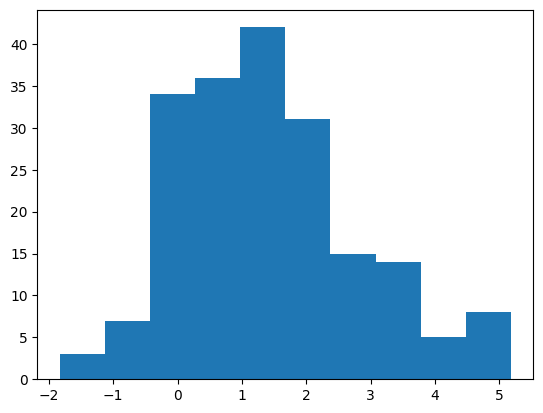

In [120]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(data)
plt.show() 

In [121]:
new_df = compressed.to_point_gdf().reset_index()
new_df["speed-errror"] = [data[0]]+data
new_df

,Timestamp,id,geometry,direction,speed,speed-errror
0,2020-06-01 08:56:08.148000,8,POINT (4.46537 50.86107),15.895840,4.803201,-1.075087
1,2020-06-01 08:56:27.699117,8,POINT (4.46574 50.86188),17.050363,4.803201,-1.075087
2,2020-06-01 08:57:03.154439,8,POINT (4.46426 50.86217),301.604597,3.078720,0.092578
3,2020-06-01 08:57:05.149227,8,POINT (4.46419 50.86221),308.774326,3.219965,0.359273
4,2020-06-01 08:57:34.996803,8,POINT (4.46338 50.86305),327.368346,3.669703,1.373348
...,...,...,...,...,...,...
191,2020-06-04 21:55:56.017546,8,POINT (4.46338 50.86305),141.750193,2.839693,3.921891
192,2020-06-04 21:56:28.292912,8,POINT (4.46419 50.86221),140.307591,3.393664,1.412693
193,2020-06-04 21:56:29.313771,8,POINT (4.46426 50.86217),128.774325,6.291904,1.122152
194,2020-06-04 21:56:56.863518,8,POINT (4.46574 50.86188),105.776984,3.962178,-0.770818


In [ ]:
new_df.to_csv("csv_results/movingpandas-DP-results.csv", index=False)


In [155]:
new_df = pd.read_csv("csv_results/movingpandas-TR-TD-results.csv")
new_df

,Timestamp,id,geometry,direction,speed,speed-errror
0,2020-06-01 08:56:08.148000,8,POINT (4.46537349999999 50.86107290000001),15.895840,4.803201,-1.075087
1,2020-06-01 08:56:27.699117,8,POINT (4.465744700000002 50.86188369999998),17.050363,4.803201,-1.075087
2,2020-06-01 08:56:32.628663,8,POINT (4.465160913014384 50.86198744640054),285.706469,8.660359,0.818235
3,2020-06-01 08:56:34.662347,8,POINT (4.4651104999999935 50.8619959),282.124104,1.805510,-1.456364
4,2020-06-01 08:56:38.639256,8,POINT (4.464652099999998 50.86207879999999),285.988035,8.440154,1.815399
...,...,...,...,...,...,...
784,2020-06-04 21:56:45.848648,8,POINT (4.464614588020888 50.86208555155184),105.915507,3.756409,0.775677
785,2020-06-04 21:56:49.996226,8,POINT (4.4651104999999935 50.8619959),105.987713,8.754868,1.590029
786,2020-06-04 21:56:52.386056,8,POINT (4.465208777397117 50.86197895073224),105.706284,3.000882,-1.591986
787,2020-06-04 21:56:56.863518,8,POINT (4.465744700000002 50.86188369999998),105.776984,8.753104,2.343458


In [156]:
np.mean(np.abs(new_df["speed-errror"].values))

1.954243022442335

In [154]:
new_df

,Timestamp,id,geometry,direction,speed,speed-errror
0,2020-06-01 08:56:08.148000,8,POINT (4.46537 50.86107),15.895840,4.803201,-1.075087
1,2020-06-01 08:56:27.699117,8,POINT (4.46574 50.86188),17.050363,4.803201,-1.075087
2,2020-06-01 08:57:03.154439,8,POINT (4.46426 50.86217),301.604597,3.078720,0.092578
3,2020-06-01 08:57:05.149227,8,POINT (4.46419 50.86221),308.774326,3.219965,0.359273
4,2020-06-01 08:57:34.996803,8,POINT (4.46338 50.86305),327.368346,3.669703,1.373348
...,...,...,...,...,...,...
191,2020-06-04 21:55:56.017546,8,POINT (4.46338 50.86305),141.750193,2.839693,3.921891
192,2020-06-04 21:56:28.292912,8,POINT (4.46419 50.86221),140.307591,3.393664,1.412693
193,2020-06-04 21:56:29.313771,8,POINT (4.46426 50.86217),128.774325,6.291904,1.122152
194,2020-06-04 21:56:56.863518,8,POINT (4.46574 50.86188),105.776984,3.962178,-0.770818


In [35]:
trajectory_df = pd.read_csv("pymove_traj_df.csv")
compressed_df = pd.read_csv("pymove_comp_df.csv")
trajectory_df

,tid,datetime,lat,lng
0,8,2020-06-01 08:56:08.148000+00:00,50.861073,4.465373
1,8,2020-06-01 08:56:09.648000+00:00,50.861100,4.465386
2,8,2020-06-01 08:56:10.398000+00:00,50.861127,4.465398
3,8,2020-06-01 08:56:10.797745+00:00,50.861146,4.465406
4,8,2020-06-01 08:56:24.229685+00:00,50.861756,4.465684
...,...,...,...,...
4937,8,2020-06-04 21:56:59.514958+00:00,50.861842,4.465724
4938,8,2020-06-04 21:56:59.943340+00:00,50.861822,4.465716
4939,8,2020-06-04 21:57:01.415195+00:00,50.861756,4.465684
4940,8,2020-06-04 21:57:14.847135+00:00,50.861146,4.465406


In [36]:
trajectory_df = mpd.Trajectory(df=trajectory_df, traj_id="1",t="datetime",x="lng", y="lat")
trajectory_df.add_speed(True, units=("m", "s"))
trajectory_df.to_point_gdf()

,tid,geometry,traj_id,speed
datetime,,,,
2020-06-01 08:56:08.148000,8,POINT (4.46537 50.86107),1,2.103037
2020-06-01 08:56:09.648000,8,POINT (4.46539 50.86110),1,2.103037
2020-06-01 08:56:10.398000,8,POINT (4.46540 50.86113),1,4.206071
2020-06-01 08:56:10.797745,8,POINT (4.46541 50.86115),1,5.257597
2020-06-01 08:56:24.229685,8,POINT (4.46568 50.86176),1,5.257573
...,...,...,...,...
2020-06-04 21:56:59.514958,8,POINT (4.46572 50.86184),1,4.206142
2020-06-04 21:56:59.943340,8,POINT (4.46572 50.86182),1,5.257474
2020-06-04 21:57:01.415195,8,POINT (4.46568 50.86176),1,5.257590


In [37]:
compressed_df = mpd.Trajectory(df=compressed_df, traj_id="1",t="datetime",x="lng", y="lat")
compressed_df.add_speed(True)
compressed_df.to_point_gdf()

,tid,geometry,traj_id,speed
datetime,,,,
2020-06-01 08:56:08.148000,8,POINT (4.46539 50.86111),1,5.171266
2020-06-01 08:56:24.229685,8,POINT (4.46572 50.86183),1,5.171266
2020-06-01 08:56:26.842959,8,POINT (4.46574 50.86188),1,2.143506
2020-06-01 08:56:29.028663,8,POINT (4.46559 50.86191),1,4.827457
2020-06-01 08:56:32.628663,8,POINT (4.46512 50.86200),1,9.684602
...,...,...,...,...
2020-06-04 21:56:52.761056,8,POINT (4.46525 50.86197),1,3.430635
2020-06-04 21:56:55.602543,8,POINT (4.46566 50.86190),1,10.451570
2020-06-04 21:56:56.863518,8,POINT (4.46573 50.86185),1,5.655342


In [38]:
trajectory_df.to_point_gdf().reset_index().to_csv("pymove_traj_df.csv", index=False)
compressed_df.to_point_gdf().reset_index().to_csv("pymove_comp_df.csv", index=False)